# Pbar for the Globe

Goal for this notebook is to take the work I did looking at a small section and apply it to global calculations. Let's see how it goes.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.colors as colors
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
import scipy.ndimage as filter
import scipy.interpolate as interpolate
from flox.xarray import xarray_reduce
from xgcm.autogenerate import generate_grid_ds
from xgcm import Grid

In [2]:
import os
os.chdir('/home.ufs/amf2288/argo-intern/funcs')
import filt_funcs as ff
import density_funcs as df

In [3]:
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize']  = 18
plt.rcParams['axes.labelsize']  = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

## Load Data

In [4]:
ds_p = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_high_res_1.nc')

## Coord interp to rho (density)

In [5]:
def interp_to_rho(rho_profile, var_profile, rho_grid, flag='group'):
    
    valid = ~np.isnan(rho_profile) & ~np.isnan(var_profile)
    rho_nonan = rho_profile[valid]
    var_nonan = var_profile[valid]

    if len(rho_nonan) < 3 or len(var_nonan) < 3:
        return np.full_like(rho_grid, np.nan)

    if flag == 'group':
        _, idx = np.unique(rho_nonan, return_index=True)
        rho_nonan = rho_nonan[idx]
        var_nonan = var_nonan[idx]

    fvar = interpolate.PchipInterpolator(rho_nonan, var_nonan, extrapolate=False)
    return fvar(rho_grid)

In [6]:
def get_ds_rho(ds_z, da_SIG0, rho_grid, variables, dim1='N_PROF', dim2='PRES'):

    xrs = []
    rho_size = rho_grid.size
    
    for var in variables:
        var_interp = xr.apply_ufunc(interp_to_rho, da_SIG0, ds_z[var],
            input_core_dims=[[dim2], [dim2]],
            output_core_dims=[['rho_grid']],
            dask_gufunc_kwargs={'output_sizes': {'rho_grid': rho_size}},
            vectorize=True,
            dask='parallelized',
            kwargs={'rho_grid': rho_grid},
            output_dtypes=[ds_z[var].dtype])
        print(f'Completed comp for {var}')
        var_interp = xr.DataArray(
            data=var_interp.data,
            dims=['N_PROF', 'rho_grid'],
            coords={'rho_grid': rho_grid, 'N_PROF': ds_z.N_PROF},
            name=var)
        xrs.append(var_interp)
        print(f'Completed {var}')
    
    ds_rho = xr.merge(xrs)
    print(f'Completed merge')
    ds_rho = ds_rho.assign_coords(LATITUDE  =(dim1, ds_z.LATITUDE.data))
    ds_rho = ds_rho.assign_coords(LONGITUDE =(dim1, ds_z.LONGITUDE.data))
    ds_rho = ds_rho.assign_coords(TIME      =(dim1, ds_z.TIME.data))
    
    return ds_rho

In [7]:
#ds_rho = get_ds_rho(ds_p, ds_p.SIG0, np.arange(21,29,0.0025), ['CT','SA','SIG0','SPICE','PRES'], dim2='PRES_INTERPOLATED')

In [8]:
#ds_rho.to_netcdf('/swot/SUM05/amf2288/ds_rho_10_30.nc')

In [9]:
ds_rho = xr.open_dataset('/swot/SUM05/amf2288/ds_rho_10_30.nc')

## Coord interp to pmean (average isopycnal depth)

In [10]:
def interp_to_pmean(var_profile, pres_profile, pmean_grid, roll):
    
    pres_da = xr.DataArray(pres_profile, dims=['rho_grid'])
    pmean_smooth = pres_da.rolling(rho_grid=roll, center=True).mean()

    try:
        valid = ~np.isnan(var_profile) & ~np.isnan(pmean_smooth)
        var_nonan = var_profile[valid]
        pmean_nonan = pmean_smooth[valid]

        # The ValueError is raised here if pmean_nonan is not strictly increasing.
        if len(pmean_nonan) < 3:
            return np.full_like(pmean_grid, np.nan)

        fvar = interpolate.PchipInterpolator(pmean_nonan, var_nonan, extrapolate=False)
        return fvar(pmean_grid)

    except ValueError:
        # Catch the error for this specific profile and return NaNs
        #print(f"ValueError")
        return np.full_like(pmean_grid, np.nan)

In [11]:
def get_ds_pmean(ds_rho, pmean_grid, variables, roll=50):
    
    xrs = []
    pmean_size = pmean_grid.size
    
    for var in variables:
        var_interp = xr.apply_ufunc(interp_to_pmean, ds_rho[var], ds_rho['PRES'],
                                   input_core_dims=[['rho_grid'], ['rho_grid']],
                                   output_core_dims=[['Pmean_grid']],
                                   dask_gufunc_kwargs={'output_sizes': {'Pmean_grid':pmean_size}},
                                   vectorize=True,
                                   dask='parallaleized',
                                   kwargs={'pmean_grid':pmean_grid, 'roll':roll},
                                   output_dtypes=[ds_rho[var].dtype])
        print(f'Completed comp for {var}')
        var_interp = xr.DataArray(
            data=var_interp.data,
            dims=['N_PROF','pmean_grid'],
            coords={'pmean_grid': pmean_grid, 'N_PROF': ds_rho.N_PROF},
            name=var)
        xrs.append(var_interp)
        print(f'Completed {var}')
        
    ds_pmean = xr.merge(xrs)
    print(f'Completed merge')
    ds_pmean = ds_pmean.assign_coords(lat  = ('N_PROF', ds_rho.LATITUDE.data))
    ds_pmean = ds_pmean.assign_coords(lon = ('N_PROF', ds_rho.LONGITUDE.data))
    #ds_pmean = ds_pmean.assign_coords(TIME      = ('N_PROF', ds_rho.TIME.data))
    
    return ds_pmean

In [12]:
#%%time
#CT_pmean = get_ds_pmean(ds_rho, np.linspace(0,2000,1001), ['CT'], roll=150)

In [13]:
#%%time
#CT_pmean.to_netcdf('/swot/SUM05/amf2288/CT_pmean_10_30.nc')

In [14]:
#%%time
#SA_pmean = get_ds_pmean(ds_rho, np.linspace(0,2000,1001), ['SA'], roll=150)

In [15]:
#%%time
#SA_pmean.to_netcdf('/swot/SUM05/amf2288/SA_pmean_10_30.nc')

In [16]:
#%%time
#SP_pmean = get_ds_pmean(ds_rho, np.linspace(0,2000,1001), ['SPICE'], roll=150)

In [17]:
#%%time
#SP_pmean.to_netcdf('/swot/SUM05/amf2288/SP_pmean_10_30.nc')

In [27]:
def get_ds_gridded(ds, lon_bins, lat_bins):
    # Step 1: Reduce using flox
    ds_binned = xarray_reduce(
        ds,
        'lon',
        'lat',
        func='mean',
        expected_groups=(
            pd.IntervalIndex.from_breaks(lon_bins),
            pd.IntervalIndex.from_breaks(lat_bins)
        ),
        fill_value=np.nan,
        skipna=True
    )

    # Step 2: Rename dimensions and variables
    ds_binned = ds_binned.rename_dims({
        'lon_bins': 'lon',
        'lat_bins': 'lat',
        #'rho_grid': 'density'
    }).rename_vars({
        'lon_bins': 'lon',
        'lat_bins': 'lat',
        #'rho_grid': 'density'
    })

    # Step 3: Replace Interval coordinates with midpoints
    def interval_midpoints(intervals):
        return np.array([interval.mid for interval in intervals])

    ds_binned = ds_binned.assign_coords({
        'lon': ('lon', interval_midpoints(ds_binned['lon'].values)),
        'lat': ('lat', interval_midpoints(ds_binned['lat'].values))
    })

    # Step 4: Generate grid and xgcm object
    ds_gridded = generate_grid_ds(ds_binned, {'X': 'lon', 'Y': 'lat'})
    grid = Grid(ds_gridded, coords={
        'X': {'center': 'lon', 'left': 'lon_left'},
        'Y': {'center': 'lat', 'left': 'lat_left'},
        'Z': {'center': 'pmean'}
    }, periodic=['X'])

    return ds_gridded, grid

In [28]:
lon_bins = np.arange(-180,181,3)
lat_bins = np.arange(-88.5,89,3)

In [18]:
CT_pmean = xr.open_dataset('/swot/SUM05/amf2288/CT_pmean_10_30.nc')
SA_pmean = xr.open_dataset('/swot/SUM05/amf2288/SA_pmean_10_30.nc')
SP_pmean = xr.open_dataset('/swot/SUM05/amf2288/SP_pmean_10_30.nc')

In [89]:
CT_pmean_grid, grid = get_ds_gridded(CT_pmean.rename({'pmean_grid':'pmean'}), lon_bins, lat_bins)
SA_pmean_grid, grid = get_ds_gridded(SA_pmean.rename({'pmean_grid':'pmean'}), lon_bins, lat_bins)
SP_pmean_grid, grid = get_ds_gridded(SP_pmean.rename({'pmean_grid':'pmean'}), lon_bins, lat_bins)

In [19]:
ds_pmean = xr.merge([CT_pmean, SA_pmean, SP_pmean])
ds_pmean = ds_pmean.rename({'pmean_grid':'pmean','N_PROF':'prof'})

## Calculations on pmean surfaces

In [21]:
lfilt=100

ct_m = ff.ds_filt_single(ds_pmean, lfilt, variable='CT', dim1='prof', dim2='pmean')
sa_m = ff.ds_filt_single(ds_pmean, lfilt, variable='SA', dim1='prof', dim2='pmean')
sp_m = ff.ds_filt_single(ds_pmean, lfilt, variable='SPICE', dim1='prof', dim2='pmean')

In [22]:
ct_e = ds_pmean.CT - ct_m
sa_e = ds_pmean.SA - sa_m
sp_e = ds_pmean.SPICE - sp_m

In [23]:
ct_e_z2 = ct_e.differentiate(coord='pmean')**2
sa_e_z2 = sa_e.differentiate(coord='pmean')**2
sp_e_z2 = sp_e.differentiate(coord='pmean')**2

In [37]:
#mesoscale variance
ct_e_z2_filt = ff.da_filt_single(ct_e_z2, lfilt, dim1='prof', dim2='pmean')
sa_e_z2_filt = ff.da_filt_single(sa_e_z2, lfilt, dim1='prof', dim2='pmean')
sp_e_z2_filt = ff.da_filt_single(sp_e_z2, lfilt, dim1='prof', dim2='pmean')

In [38]:
#microscale variance
ct_m_z2 = ct_m.differentiate(coord='pmean')**2
sa_m_z2 = sa_m.differentiate(coord='pmean')**2
sp_m_z2 = sp_m.differentiate(coord='pmean')**2

In [39]:
ct_e_z2_filt = ct_e_z2_filt.to_dataset(name='ct_e_z2_filt')
sa_e_z2_filt = sa_e_z2_filt.to_dataset(name='sa_e_z2_filt')
sp_e_z2_filt = sp_e_z2_filt.to_dataset(name='sp_e_z2_filt')

ct_m_z2 = ct_m_z2.to_dataset(name='ct_m_z2')
sa_m_z2 = sa_m_z2.to_dataset(name='sa_m_z2')
sp_m_z2 = sp_m_z2.to_dataset(name='sp_m_z2')

In [40]:
ct_e_z2_filt_grid, grid = get_ds_gridded(ct_e_z2_filt, lon_bins, lat_bins)
sa_e_z2_filt_grid, grid = get_ds_gridded(sa_e_z2_filt, lon_bins, lat_bins)
sp_e_z2_filt_grid, grid = get_ds_gridded(sp_e_z2_filt, lon_bins, lat_bins)

ct_m_z2_grid, grid = get_ds_gridded(ct_m_z2, lon_bins, lat_bins)
sa_m_z2_grid, grid = get_ds_gridded(sa_m_z2, lon_bins, lat_bins)
sp_m_z2_grid, grid = get_ds_gridded(sp_m_z2, lon_bins, lat_bins)

In [48]:
K_rho_x = xr.open_dataset('/swot/SUM05/amf2288/global_diff.nc').K.drop_vars(['z_l','z_r','lon_r','lat_r']).rename({'lon_l':'lon_left','lat_l':'lat_left','z_c':'pmean','lat_c':'lat','lon_c':'lon'})

In [51]:
K_rho_x = K_rho_x.interp(pmean=ct_e_z2_filt_grid.pmean)

In [70]:
ct_var2 = ct_e_z2_filt_grid.rename({'ct_e_z2_filt':'ct_var2'})
sa_var2 = sa_e_z2_filt_grid.rename({'sa_e_z2_filt':'sa_var2'})
sp_var2 = sp_e_z2_filt_grid.rename({'sp_e_z2_filt':'sp_var2'})

ct_var3 = ct_m_z2_grid.rename({'ct_m_z2':'ct_var3'})
sa_var3 = sa_m_z2_grid.rename({'sa_m_z2':'sa_var3'})
sp_var3 = sp_m_z2_grid.rename({'sp_m_z2':'sp_var3'})

ct2_VPR = (K_rho_x*ct_var2).rename({'ct_var2':'ct2_VPR'})
sa2_VPR = (K_rho_x*sa_var2).rename({'sa_var2':'sa2_VPR'})
sp2_VPR = (K_rho_x*sp_var2).rename({'sp_var2':'sp2_VPR'})

ct3_VPR = (K_rho_x*ct_var3).rename({'ct_var3':'ct3_VPR'})
sa3_VPR = (K_rho_x*sa_var3).rename({'sa_var3':'sa3_VPR'})
sp3_VPR = (K_rho_x*sp_var3).rename({'sp_var3':'sp3_VPR'})

In [71]:
ct2_frac = (ct_var2)/(ct_var2 + ct_var3)
sa2_frac = (sa_var2)/(sa_var2 + sa_var3)
sp2_frac = (sp_var2)/(sp_var2 + sp_var3)

In [92]:
pmean = xr.merge([K_rho_x.rename('K_rho'),
                  CT_pmean_grid, SA_pmean_grid, SP_pmean_grid,
                  ct_var2, sa_var2, sp_var2,
                  ct_var3, sa_var3, sp_var3,
                  ct2_VPR, sa2_VPR, sp2_VPR,
                  ct3_VPR, sa3_VPR, sp3_VPR,
                  ct2_frac,sa2_frac,sp2_frac])

In [93]:
pmean

<xarray.Dataset> Size: 907MB
Dimensions:   (lat: 59, lon: 120, pmean: 1001, lon_left: 120, lat_left: 59)
Coordinates:
  * lat       (lat) float64 472B -87.0 -84.0 -81.0 -78.0 ... 78.0 81.0 84.0 87.0
  * lon       (lon) float64 960B -178.5 -175.5 -172.5 ... 172.5 175.5 178.5
  * pmean     (pmean) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * lon_left  (lon_left) float64 960B -180.0 -177.0 -174.0 ... 171.0 174.0 177.0
  * lat_left  (lat_left) float64 472B -88.5 -85.5 -82.5 -79.5 ... 79.5 82.5 85.5
Data variables: (12/16)
    K_rho     (pmean, lon, lat) float64 57MB nan nan nan nan ... nan nan nan nan
    CT        (pmean, lon, lat) float64 57MB nan nan nan nan ... nan nan nan nan
    SA        (pmean, lon, lat) float64 57MB nan nan nan nan ... nan nan nan nan
    SPICE     (pmean, lon, lat) float64 57MB nan nan nan nan ... nan nan nan nan
    ct_var2   (pmean, lon, lat) float64 57MB nan nan nan nan ... nan nan nan nan
    sa_var2   (pmean, lon, lat) float64 57MB nan nan nan nan ... nan nan nan nan
    ...        ...
    ct2_VPR   (pmean, lon, lat) float64 57MB nan nan nan nan ... nan nan nan nan
    sa2_VPR   (pmean, lon, lat) float64 57MB nan nan nan nan ... nan nan nan nan
    sp2_VPR   (pmean, lon, lat) float64 57MB nan nan nan nan ... nan nan nan nan
    ct3_VPR   (pmean, lon, lat) float64 57MB nan nan nan nan ... nan nan nan nan
    sa3_VPR   (pmean, lon, lat) float64 57MB nan nan nan nan ... nan nan nan nan
    sp3_VPR   (pmean, lon, lat) float64 57MB nan nan nan nan ... nan nan nan nan

In [94]:
pmean.to_netcdf('/swot/SUM05/amf2288/full_pmean.nc')

## CT, SA, SIG0, SPICE Maps

In [97]:
pmean = xr.open_dataset('/swot/SUM05/amf2288/full_pmean.nc')

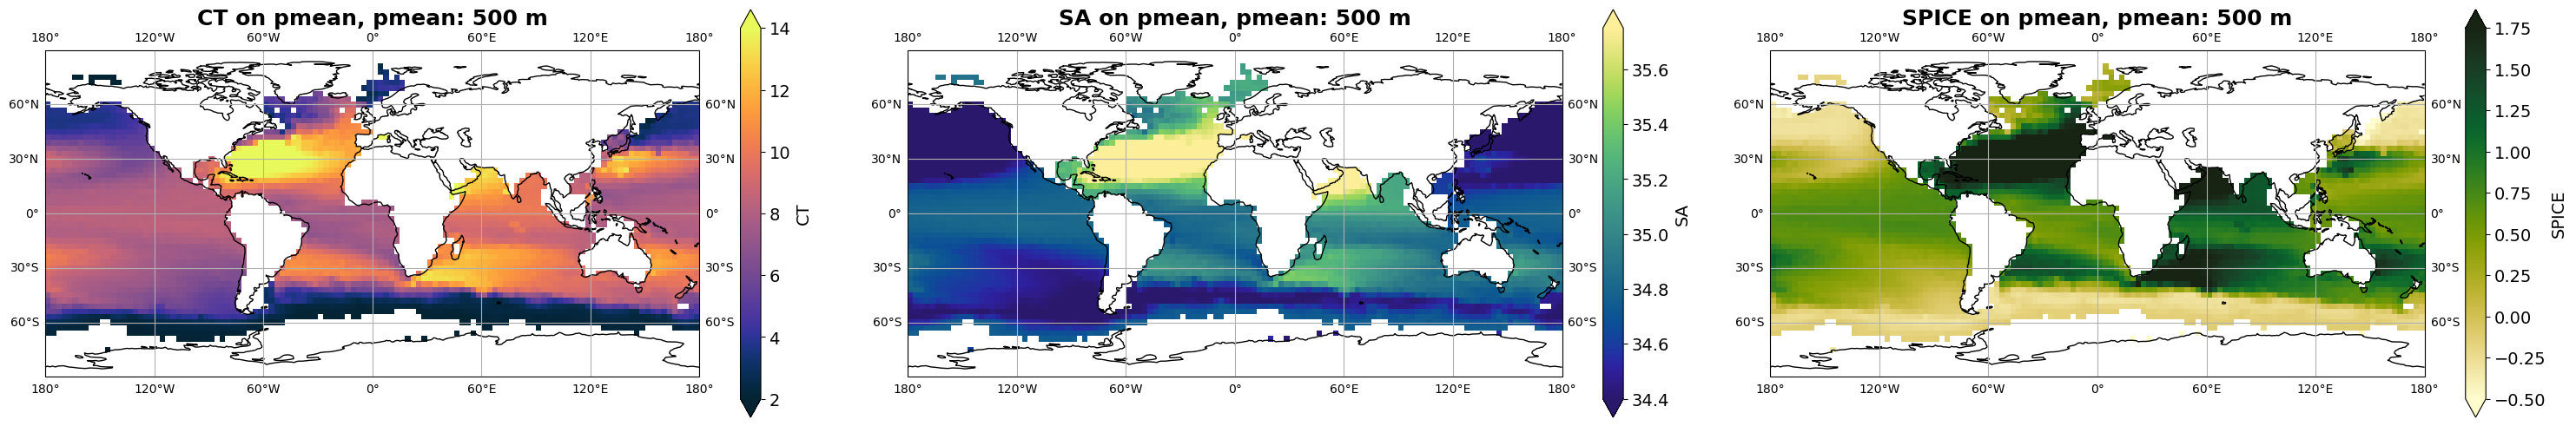

In [110]:
depth = 500

ct_cmap, sa_cmap, sp_cmap = cmo.thermal, cmo.haline, cmo.speed
ct_norm = colors.Normalize(vmin=2, vmax=14)
sa_norm = colors.Normalize(vmin=34.4, vmax=35.75)
sp_norm = colors.Normalize(vmin=-0.5, vmax=1.75)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 5),subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten() # Flatten axes for easy iteration

ax = axes[0]
pmean.sel(pmean=depth, method='nearest').CT.plot(x='lon', y='lat', ax=ax, transform=ccrs.PlateCarree(), cmap=ct_cmap, norm=ct_norm)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ax.set_title(f'CT on pmean, pmean: {depth} m')

ax = axes[1]
pmean.sel(pmean=depth, method='nearest').SA.plot(x='lon', y='lat', ax=ax, transform=ccrs.PlateCarree(), cmap=sa_cmap, norm=sa_norm)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ax.set_title(f'SA on pmean, pmean: {depth} m')

ax = axes[2]
pmean.sel(pmean=depth, method='nearest').SPICE.plot(x='lon', y='lat', ax=ax, transform=ccrs.PlateCarree(), cmap=sp_cmap, norm=sp_norm)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ax.set_title(f'SPICE on pmean, pmean: {depth} m')


plt.tight_layout()
plt.show()